In [1]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
import pandas as pd
import numpy as np
import scipy
import sympy
import math
import matplotlib.pyplot as plt

In [3]:
#pip install sxs

In [4]:
import sxs
print(sxs.__file__)
print(sxs.__version__)
print(dir(sxs))

/home/ajt6830/.local/share/mamba/envs/pysr_env/lib/python3.11/site-packages/sxs/__init__.py
2025.0.17
['Catalog', 'HorizonQuantities', 'Horizons', 'Metadata', 'Simulation', 'Simulations', 'TimeSeries', 'WaveformModes', 'WaveformModesDict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'astronomical_unit', 'catalog', 'citation', 'cite', 'doi_prefix', 'doi_url', 'file_format', 'guvectorize', 'handlers', 'horizons', 'importlib_metadata', 'jit', 'lev_number', 'load', 'load_lvc', 'load_via_sxs_id', 'loadcontext', 'local_simulations', 'm_sun_in_meters', 'm_sun_in_seconds', 'metadata', 'parsec_in_meters', 'read_config', 'rpdmb', 'rpxmb', 'simulations', 'solar_mass_parameter', 'spectre_cce_v1', 'speed_of_light', 'sxs_directory', 'sxs_id', 'sxs_id_to_url', 'time_series', 'to_lvc_conventions', 'utilities', 'vectorize', 'version_info', 'waveforms', 'write_config', 'write_local_simulations', 'zenodo']


In [5]:
def dataframe(non_eccentric, non_spinning, aligned_spin, not_deprecated):
    df = sxs.load("dataframe")
    df = df.loc[np.isfinite(df["common_horizon_time"])]
    if non_eccentric:
        df = df.loc[df['reference_eccentricity'] < 0.01]
    if non_spinning:
        df = df.loc[df["reference_dimensionless_spin1_mag"] < 0.001]
        df = df.loc[df["reference_dimensionless_spin2_mag"] < 0.001]
    if aligned_spin:
        df = df.loc[df["reference_dimensionless_spin1_x"] < 0.001]
        df = df.loc[df["reference_dimensionless_spin2_x"] < 0.001]
        df = df.loc[df["reference_dimensionless_spin1_y"] < 0.001]
        df = df.loc[df["reference_dimensionless_spin2_y"] < 0.001]
    if not_deprecated:
        df = df.loc[df["deprecated"] == False]
        df = df.drop('SXS:BBH:0621') #All of my best models were having a hard time fitting CHT for this simulation. Seems like an outlier
    return df    
    
df = dataframe(non_eccentric = True, non_spinning = False, aligned_spin = False, not_deprecated = True)
print(len(df))

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.
3526


In [6]:
ref_orb_period = 2*np.pi/df["reference_orbital_frequency_mag"]
CHT = df["common_horizon_time"] - df["reference_time"]
CHT = CHT/np.max(CHT)

In [7]:
#I have this just to give me an idea of how I will be normalizing my data for each simulation parameter
print(np.max(ref_orb_period))
print(np.max(df["reference_mass_ratio"]))
print(np.max(df["reference_chi_eff"]))
print(np.max(df["reference_chi1_perp"]))
print(np.max(df["reference_chi2_perp"]))

1255.9423637835212
19.996283628748095
0.9979951161269466
0.9498992712861546
0.9497748830152188


In [8]:

#Here, we are normalizing each of the simulation parameters to be between 0 and 1, except for chi_eff which is already normalized to be zero-centered.
#I am doing this because it is simpler than normalizing everything to be zero-centered, and I didn't see any obvious improvements in training when making
#all the data zero-centered.

period_norm = ref_orb_period/np.max(ref_orb_period)
q_norm = df["reference_mass_ratio"]/np.max(df["reference_mass_ratio"])

#We are not renormalizing chi_eff because it seems that training is actually less effective if I normalize it to be between 0 and 1
#chi_eff_norm = (df["reference_chi_eff"] + 1)/2

simulations = np.column_stack((period_norm, q_norm, df["reference_chi_eff"], df["reference_chi1_perp"], df["reference_chi2_perp"]))

In [9]:
#Here, we can normalize each of the simulation parameters to be zero-centered. I don't believe this is actually more effective

'''
period_norm = ref_orb_period - np.mean(ref_orb_period)
q_norm = df["reference_mass_ratio"] - np.mean(df["reference_mass_ratio"])
chi1_perp_norm = df["reference_chi1_perp"] - np.mean(df["reference_chi1_perp"])
chi2_perp_norm = df["reference_chi2_perp"] - np.mean(df["reference_chi2_perp"])

period_norm = period_norm/np.max(period_norm)
q_norm = q_norm/np.max(q_norm)

simulations = np.column_stack((period_norm, q_norm, df["reference_chi_eff"], chi1_perp_norm, chi2_perp_norm))
'''

'\nperiod_norm = ref_orb_period - np.mean(ref_orb_period)\nq_norm = df["reference_mass_ratio"] - np.mean(df["reference_mass_ratio"])\nchi1_perp_norm = df["reference_chi1_perp"] - np.mean(df["reference_chi1_perp"])\nchi2_perp_norm = df["reference_chi2_perp"] - np.mean(df["reference_chi2_perp"])\n\nperiod_norm = period_norm/np.max(period_norm)\nq_norm = q_norm/np.max(q_norm)\n\nsimulations = np.column_stack((period_norm, q_norm, df["reference_chi_eff"], chi1_perp_norm, chi2_perp_norm))\n'

In [10]:
#Converting straight from a pandas dataframe to a Torch tensor might be a problem at some point (iloc nonsense)
CHT = torch.tensor(CHT, dtype=torch.float)
simulations = torch.tensor(simulations, dtype=torch.float)

/tmp/ipykernel_19856/2178330711.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CHT = torch.tensor(CHT, dtype=torch.float)


In [11]:
from sklearn.model_selection import train_test_split

test_frac = 0.2
data_train, data_test, label_train, label_test = train_test_split(simulations, CHT, test_size = test_frac, random_state = 42)
train_num = (1 - test_frac)*len(simulations)
test_num = test_frac*len(simulations)

In [12]:
class CustomDataset():
    def __init__(self, labels, data):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sim = self.data[idx]
        label = self.labels[idx]
        return sim, label

training_sims = CustomDataset(label_train, data_train)
testing_sims = CustomDataset(label_test, data_test)

from torch.utils.data import DataLoader

batch_num = 64
train_dataloader = DataLoader(training_sims, batch_size=batch_num, shuffle=True)
test_dataloader = DataLoader(testing_sims, batch_size=batch_num, shuffle=True)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self, activation_function):
        super().__init__()
        self.fc1 = nn.Linear(5, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 1)
        self.activation_function = activation_function
    
    def forward(self, x):
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
import torch.optim as optim

def weighted_MSE(outputs, labels):
   #specifying the batch size
   batch_size = outputs.size()[0]
  
   return torch.sum(((outputs - labels)/labels)**2)/batch_size #For every simulation in a batch, I take the difference between the CHT proportion
    #associated with that simulation and the CHT proportion predicted by my model weighted by the simulation proportion. This should give the proportion
    #residual of my model's CHT predictions, then I sum up over the batch and divide by the size of the batch
    
criterion = weighted_MSE

In [15]:
activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'LeakyReLU': nn.LeakyReLU()
}

train_losses = {}
test_losses = {}
best_losses = {}
best_epochs = {}
# Train and test the model with different activation functions

for name, activation_function in activation_functions.items():
    print(f"Training with {name} activation function...")
 
    net = Net(activation_function)
    optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

    epoch_num = 10000
    epochs = np.arange(epoch_num)
    train_losses[name] = np.zeros(epoch_num)
    test_losses[name] = np.zeros(epoch_num)
    best_losses[name] = 1000000
    
    for epoch in range(epoch_num): #loop over the dataset multiple times
        #enumerate assigns each entry in train_dataloader, a single batch, to the variable data. i is a number enumerating each batch in train
        train_running_loss = 0.0
        test_running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            #inputs is a list of all the simulations in the batch and labels is the list of all associated common horizon times in the batch
            inputs, labels = data
            
            #zero the parameter gradients between batches ran through the network so that they don't blow up
            optimizer.zero_grad()
            
            #This block contains our forward + backward + optimize steps
            #Here we convert the simulation parameter tensors into the float32 tensor type
            inputs = inputs.float()
            #Here we actually run the simulation parameters through the network and get the network's guess for the CHT of each simulation in the batch
            outputs = net(inputs)
            #Here we "squeeze" out any single value arrays. Basically get rid of unneeded brackets
            outputs = outputs.squeeze()
            #Ensure the output is a float32 value
            outputs = outputs.float()
            # Ensure the labels are float32 (if they aren't already)
            labels = labels.float()
            #Here we compute the weighted loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            train_running_loss += loss.item()
            #This segment of code effectively checks if we have ran through the entire dataset during training. It does this by checking if the number
            #of batches loaded is equal to the number of batches the dataset can be divided into rounded up. It then prints the ith iteration through the
            #dataset that we are currently on and the average loss per image for that iteration through the dataset
            if i  == math.trunc(train_num/batch_num):
                train_avg_loss = train_running_loss/(i+1)
                #print(f'[{epoch + 1}] loss: {train_avg_loss:.6f}')
                train_losses[name][epoch] = 100*np.sqrt(train_avg_loss) #averages running_loss over all the batches in one iteration of the dataset
                
        #This is where we save the best test dataset and determine the accuracy of the neural network
        for j, data in enumerate(test_dataloader):
            inputs, labels = data
    
            inputs = inputs.float()
            
            outputs = net(inputs)

            outputs = outputs.squeeze()

            outputs = outputs.float()

            labels = labels.float()

            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            
            if j  == math.trunc(test_num/batch_num):
                test_avg_loss = 100*np.sqrt(test_running_loss/(j+1))
                test_losses[name][epoch] = test_avg_loss
                if test_avg_loss < best_losses[name]:
                    best_losses[name] = test_avg_loss
                    best_epochs[name] = epoch

Training with ReLU activation function...
Training with Sigmoid activation function...
Training with LeakyReLU activation function...


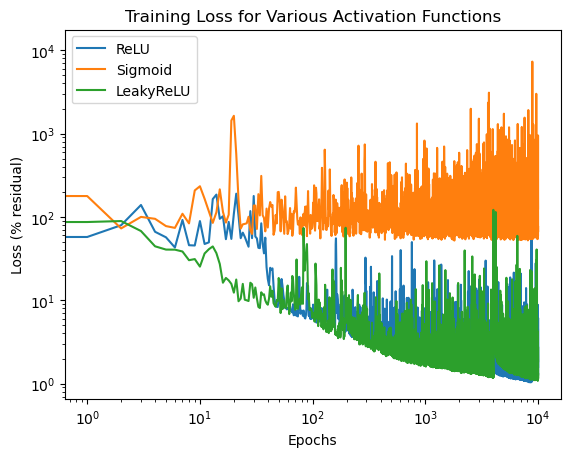

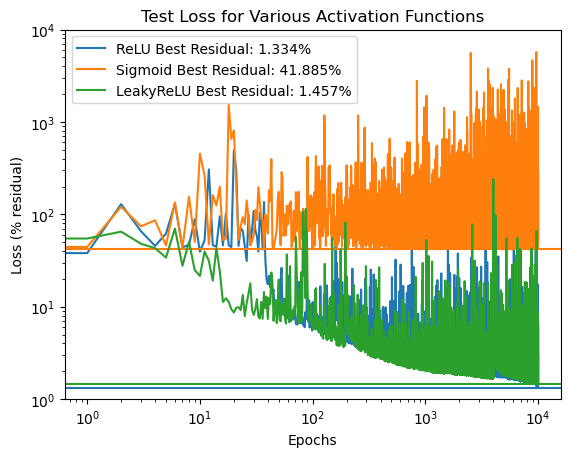

In [20]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
i = 0
fig, ax = plt.subplots()
for name, activation_function in activation_functions.items():
    plt.plot(epochs, train_losses[name], label = name)

plt.xscale('log')
plt.yscale('log')
plt.title("Training Loss for Various Activation Functions")
plt.xlabel("Epochs")
plt.ylabel("Loss (% residual)")
plt.legend()
plt.savefig("train_loss_act_fn.png")
plt.show()

fig, ax = plt.subplots()
for name, activation_function in activation_functions.items():
    plt.plot(epochs, test_losses[name])
    plt.axhline(best_losses[name], label = f"{name} Best Residual: {round(best_losses[name], 3)}%", color = colors[i])
    i += 1

plt.xscale('log')
plt.yscale('log')
ax.set_ylim(1, 10000)
plt.title("Test Loss for Various Activation Functions")
plt.xlabel("Epochs")
plt.ylabel("Loss (% residual)")
plt.legend()
plt.savefig("test_loss_act_fn.png")
plt.show()